# Gesture Recognition

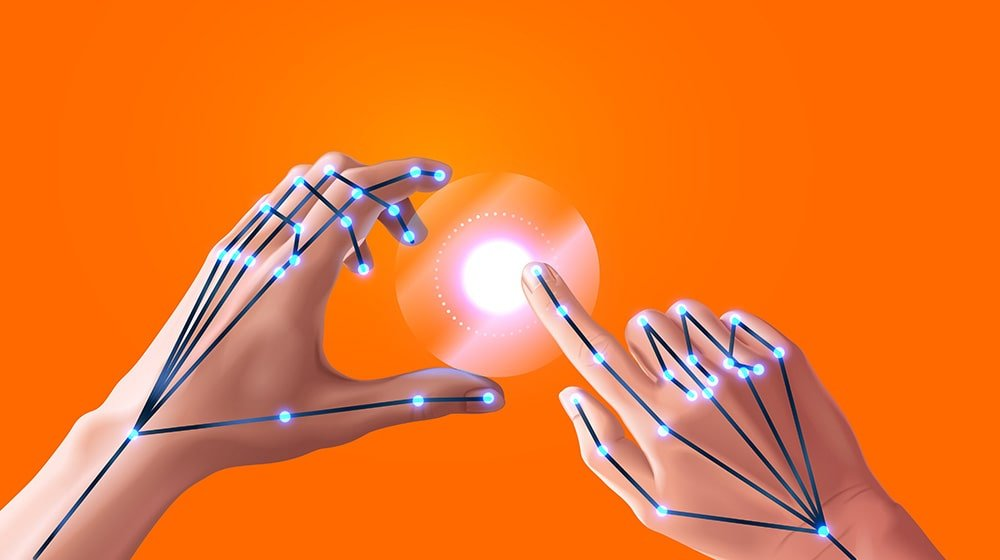

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
import datetime

import warnings
warnings.filterwarnings("ignore")

#### We set the random seed value in order to maintain the reproducibility of the network and also for results not to vary drastically

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(30)

- Now we store training and validation folders in separate lists and shuffle them so that our model should not overfit

In [3]:
train_doc = np.random.permutation(open("/datasets/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open("/datasets/Project_data/val.csv").readlines())
batch_size = 64  # We have to experiment with it..

In [4]:
print(train_doc[:5])

['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n']


In [5]:
# Specifying constants
num_classes = 5  # total no of classes
ht = 84         # height of image (desired)
wd = 84         # width of image (desired)

## Data Generator
- This is the most important part of the code
- Data Generators help to utilise the system memory efficiently by feeding the data into batches
- We should preprocess the data before feeding into the CNN
- Preprocessing including cropping, resizing, normalizing the data, etc
- Videos captured from different cameras might have different dimensions(resolution) and that needs to be taken care of with image preprocessing

In [6]:
tot_frames = len([0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29])
print("Total Frames:", tot_frames)

Total Frames: 18


In [7]:
# Using this generator
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,tot_frames,ht,wd,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,tot_frames,ht,wd,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [8]:
current_dt_time = datetime.datetime.now()
train_path = "/datasets/Project_data/train"
val_path = "/datasets/Project_data/val"

train_videos = len(train_doc)
val_videos = len(val_doc)
print("# training sequences(videos):", train_videos)
print('# validation sequences(videos):', val_videos)

num_epochs = 30
print('# no of epochs:', num_epochs)

# training sequences(videos): 663
# validation sequences(videos): 100
# no of epochs: 30


## Model Building
Here we are using 3D Convolution Neural Network. So we should use `Conv3D` and `MaxPooling3D` layers instead of `Conv2D` and `MaxPooling2D` layers\
Last layer is `softmax` and model should be built in such a way that it should be able to fit in the memory of webcam

In [9]:
# Importing necessary libraries
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Flatten, Dense, MaxPool3D, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers

### Model 1

Creating the model without `BatchNormalization` and `Dropout` and activation function `ReLU`

In [14]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [LR]

In [39]:
conv3d_model1 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
# COMPILING THE MODEL
conv3d_model1.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model1.summary())

# GENERATORS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1
    
history = conv3d_model1.fit(train_generator,
          epochs=15,  # keeping no of epochs as 5 for now
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 10, 10, 64)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)            

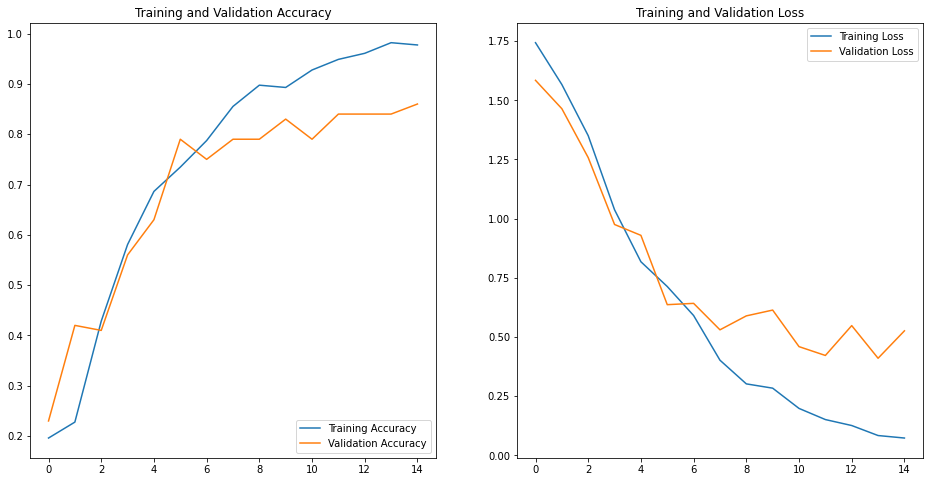

In [40]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
conv3d_model1.save('model-1.h5')

> Model is able to "learn" on training dataset very well. But we have slight overfitting on the model

## Model 2

Creating the model with `BatchNormalization` and `Dropout` to try reduce the overfitting\
Also increasing the batch size to 128

In [42]:
conv3d_model2 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    BatchNormalization(),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model2.summary())

batch_size = 128
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model2.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
batch_normalization_203 (Bat (None, 18, 84, 84, 16)    64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
batch_normalization_204 (Bat (None, 9, 42, 42, 32)     128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 4, 21, 21, 64)    

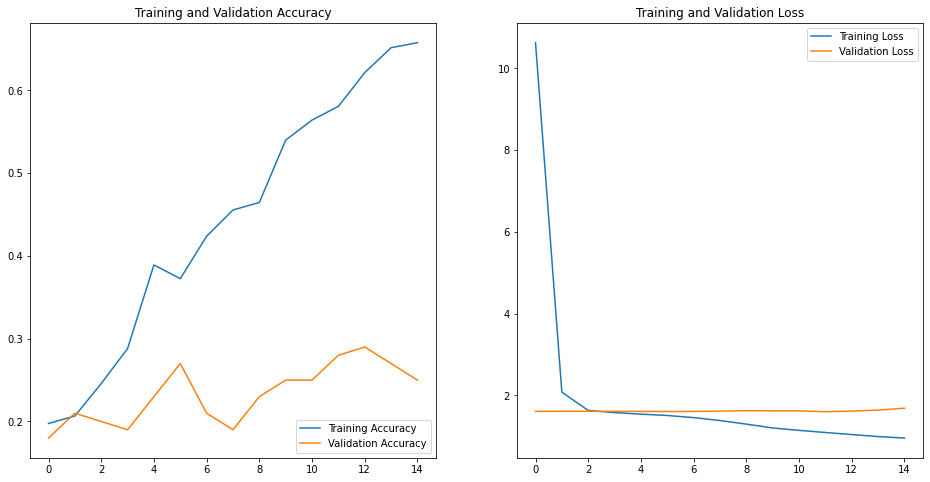

In [43]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
conv3d_model2.save('model-2.h5')

Thus it is evident that batch size = 128 is not optimal choice\
We should use batch size = 64\
Because model is overfitting. The probable reason for this can be batch size = 128 might not be optimal for validation set though it is good for training set

## Model 3
Trying model similar to the `conv3d_model1` i.e **Model1**. But this time we will try reducing the parameters by reducing no of neurons in the last hidden layer and keeping `batch_size = 64`

In [45]:
conv3d_model3 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model3.summary())

# SETTING THE BATCH SIZE
batch_size = 64

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model3.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 2, 10, 10, 64)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)            

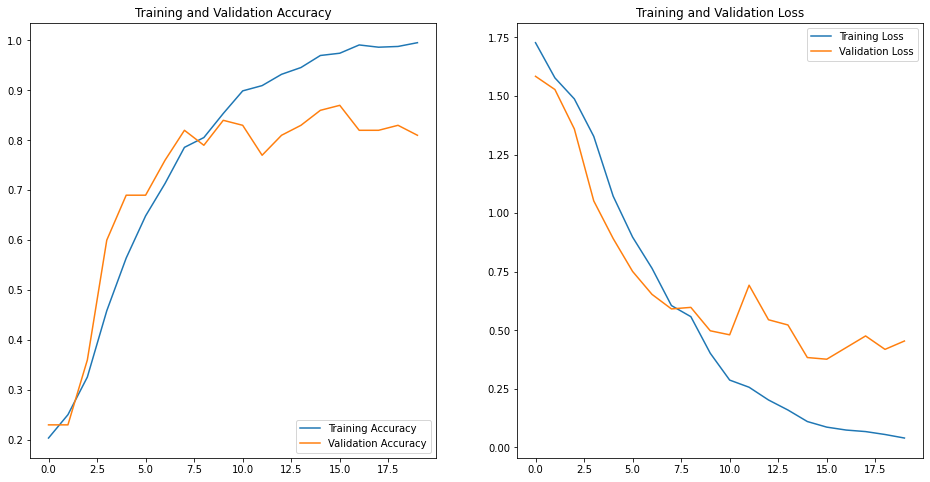

In [46]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
conv3d_model3.save('model-3.h5')

### Inferences:
- **Model 3** has least no of parameters as compared to Model 1 and Model 2
- Accuracy of model 3 is similar to that of model 1 and that too with half the parameters of model 1
- It makes model 3 the best choice for 3D CNN architecture

## Model 4
- Trying with batch size = 32 with same model as model 3

In [48]:
conv3d_model4 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model4.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model4.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 2, 10, 10, 64)     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12800)            

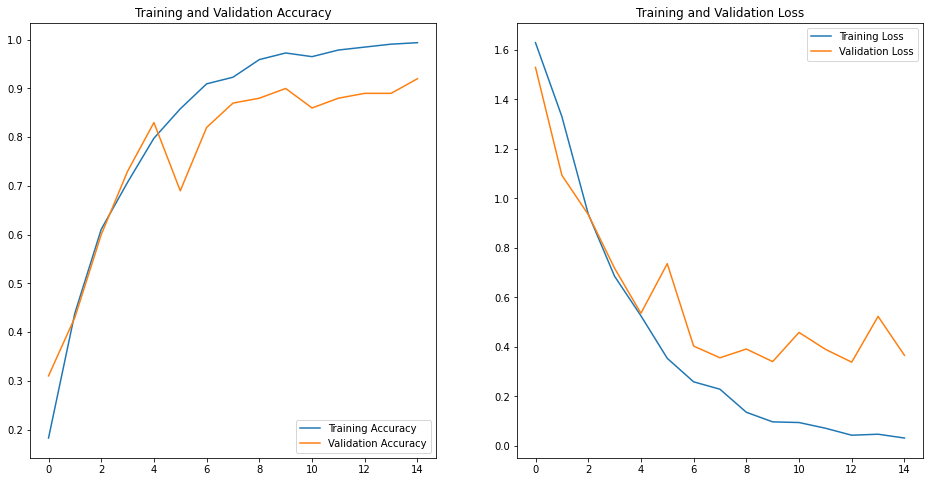

In [49]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
conv3d_model4.save('model-4.h5')

### Inferences
- Batch size = 32 turns out to be best batch size
- Gives the least overfit model

## Model 5

- Lets do some modifications in the model
> Adding 1 more hidden layers before output layer in previous model\
> Batch size = 32\
> Using dropouts = 25%

In [51]:
conv3d_model5 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(tot_frames,ht,wd,3), activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(128, (3,3,3),padding='same', activation='relu'),
    MaxPool3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(num_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model5.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model5.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model5.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 9, 42, 42, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 9, 42, 42, 32)     13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 4, 21, 21, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 4, 21, 21, 64)     55360     
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 2, 10, 10, 64)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 2, 10, 10, 128)   

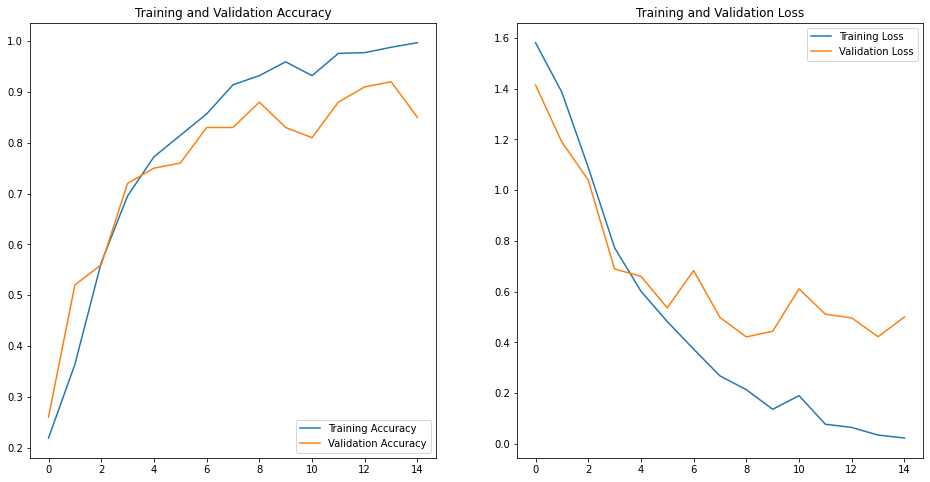

In [52]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
conv3d_model5.save('model-5.h5')

## Model 6
- In this model, we convert images to grayscale from RGB
- This will help us get results faster as memory consumed for each batch will be reduced
- We have to modify our existing `data generator` for converting images to grayscale

In [54]:
from skimage import io
from skimage.color import rgb2gray

In [55]:
def generator_grayscale(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,tot_frames,ht,wd))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = rgb2gray(imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32))
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:] = image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,tot_frames,ht,wd))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = rgb2gray(imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32))
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:] = image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [56]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [58]:
conv2d_model6 = Sequential([
    Conv2D(16, (3,3),padding='same', input_shape=(tot_frames,ht,wd), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])


# COMPILE THE MODEL
conv2d_model6.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv2d_model6.summary())

# SETTING THE BATCH SIZE
batch_size = 64

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator_grayscale(train_path,train_doc,batch_size)
val_generator = generator_grayscale(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv2d_model6.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 18, 84, 16)        12112     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 42, 16)         0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 9, 42, 32)         4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 21, 32)         0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 4, 21, 64)         18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 10, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)             

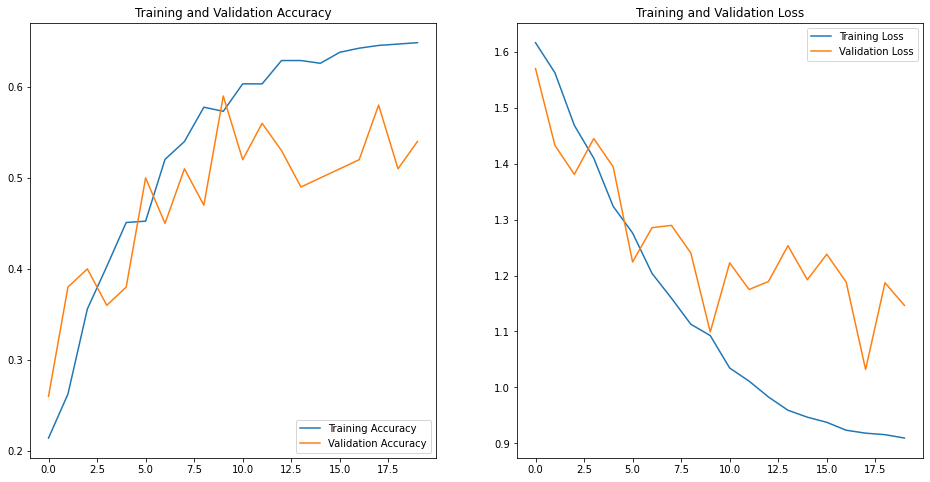

In [59]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
conv2d_model6.save('model-6.h5')

## Model 7
- The model is overfitting after 15 iterations
- We will use *Dropout* to tackle overfitting
- Also, will increase neurons in last hidden layer to push training accuracy furthur

In [61]:
conv2d_model7 = Sequential([
    Conv2D(16, (3,3),padding='same', input_shape=(tot_frames,ht,wd), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(5, activation='softmax')
])


# COMPILE THE MODEL
conv2d_model7.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv2d_model7.summary())

# SETTING THE BATCH SIZE
batch_size = 64

# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator_grayscale(train_path,train_doc,batch_size)
val_generator = generator_grayscale(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv2d_model7.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 18, 84, 16)        12112     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 42, 16)         0         
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 9, 42, 32)         4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 21, 32)         0         
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 4, 21, 64)         18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 10, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1280)             

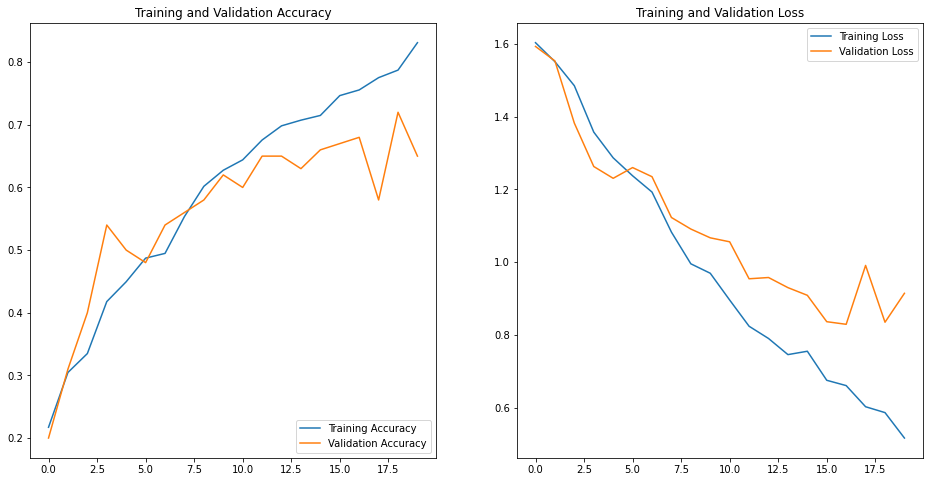

In [62]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
conv2d_model7.save('model-7.h5')

### Inferences:
- Grayscale model doesn't perform well as it results in lot of data

## Now trying CNN-RNN Architecture
- Using transfer learning for 2D CNN layer
- Stacking GRU model on top of it

*Note:* Here we prefer to use GRU instead of LSTM as they both give similar accuracy and GRU has 3 gates while LSTM has 4, which reduces no of parameters for GRU

In [10]:
pip install tensorflow_hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, LSTM

## 1. Using ResNet50 pre-trained model for transfer learning

In [12]:
from tensorflow.keras.applications import ResNet50

In [15]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 1
cnn_rnn_m1 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m1.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m1.fit(train_generator,
          epochs=15, # keeping 5 epochs for now
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 64)            24767424  
_________________________________________________________________
gru_2 (GRU)                  (None, 18, 160)           108480    
_________________________________________________________________
gru_3 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 25,380,357
Trainable params: 1,792,645
Non-trainable params: 23,587,712
__________________________________

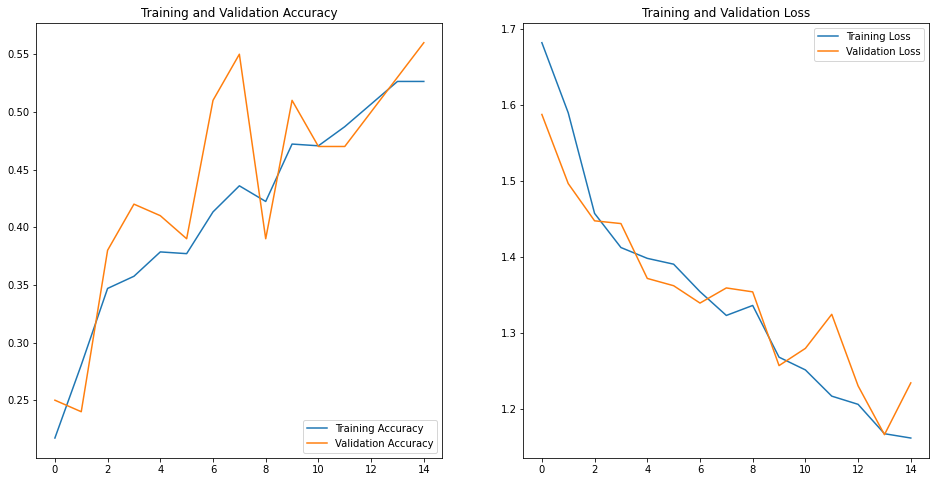

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
cnn_rnn_m1.save('model-8.h5')

- Increasing last hidden layer neurons in pre-trained model (ResNet50) to 128

In [18]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(128, activation='relu')(x)  # here we have changed neurons
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 1
cnn_rnn_m2 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m2.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m2.fit(train_generator,
          epochs=15,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 18, 128)           25947136  
_________________________________________________________________
gru_4 (GRU)                  (None, 18, 160)           139200    
_________________________________________________________________
gru_5 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               41088     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
Total params: 26,590,789
Trainable params: 3,003,077
Non-trainable params: 23,587,712
__________________________________

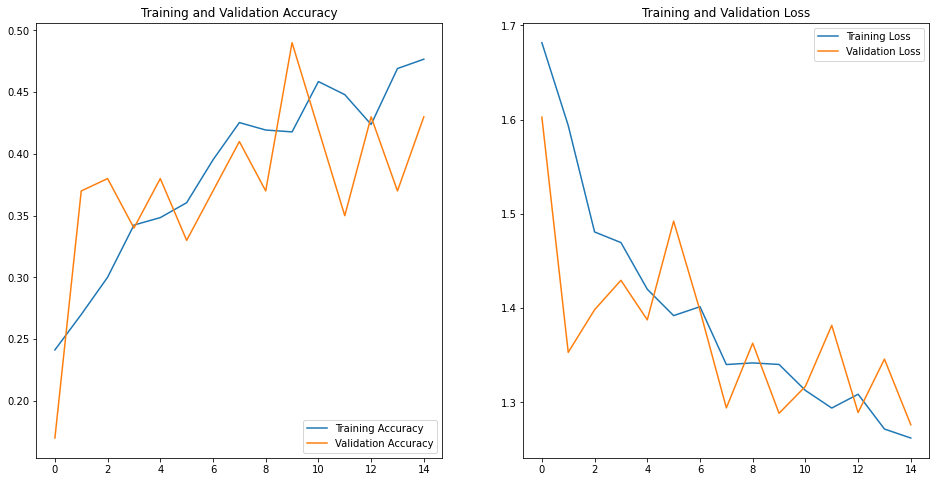

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- In this model also, results are similar to the first model
- No significant change was observed
- Let's switch our model to ResNet50V2 which is advanced version of ResNet50

In [20]:
cnn_rnn_m2.save('model-9.h5')

## 2. Using ResNet50V2 pre-trained model for transfer learning

In [21]:
from tensorflow.keras.applications import ResNet50V2

- batch_size = 64
- Last hidden layer neurons in ResNet50V2 = 64
- epochs = 10

In [22]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 3
cnn_rnn_m3 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    GRU(160, return_sequences=True),
    GRU(320),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m3.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m3.fit(train_generator,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 18, 64)            24744512  
_________________________________________________________________
gru_6 (GRU)                  (None, 18, 160)           108480    
_________________________________________________________________
gru_7 (GRU)                  (None, 320)               462720    
_________________________________________________________________
dropout_3 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               41088     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 25,357,445
Trainable params: 1,792,645
Non-trainable params: 23,564,800
__________________________________

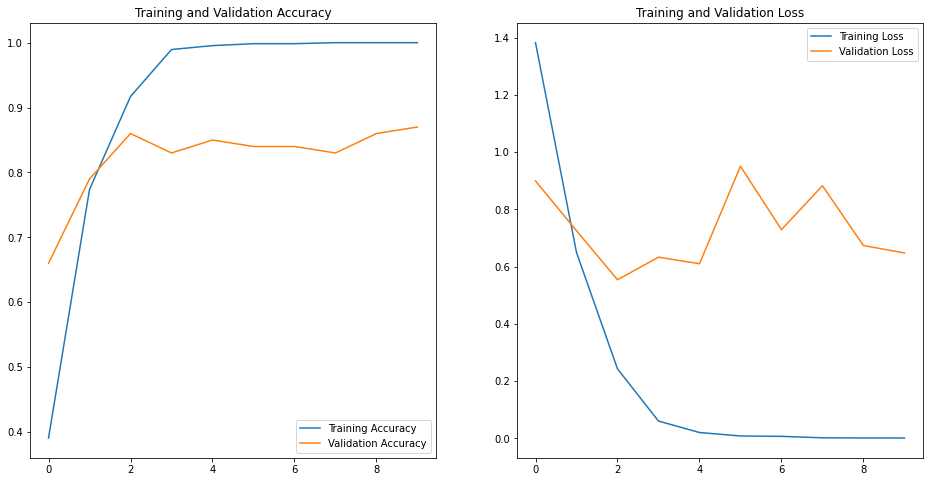

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
cnn_rnn_m3.save('model-10.h5')

- This is the best model so far in the CNN-RNN Architecture

## 3. Trying LSTM instead of GRU

In [25]:
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(ht,wd,3))
x = base_model.output
x = Flatten()(x)
features = Dense(128, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# CNN-RNN MODEL 3
cnn_rnn_m5 = Sequential([
    TimeDistributed(conv_model, input_shape=(tot_frames,ht,wd,3)),
    LSTM(160, return_sequences=True),
    LSTM(320),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),   # Adding this new layer
    Dense(num_classes, activation='softmax')
])

# COMPILING THE MODEL
cnn_rnn_m5.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
print(cnn_rnn_m5.summary())

batch_size = 64
# For training set
if (train_videos%batch_size) == 0:
    steps_per_epoch = int(train_videos/batch_size)
else:
    steps_per_epoch = int(train_videos//batch_size) + 1
    
# For validation set
if (val_videos%batch_size) == 0:
    validation_steps = int(val_videos/batch_size)
else:
    validation_steps = int(val_videos//batch_size) + 1

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = cnn_rnn_m5.fit(train_generator,
          epochs=5,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 18, 128)           25924224  
_________________________________________________________________
lstm (LSTM)                  (None, 18, 160)           184960    
_________________________________________________________________
lstm_1 (LSTM)                (None, 320)               615680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               41088     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                

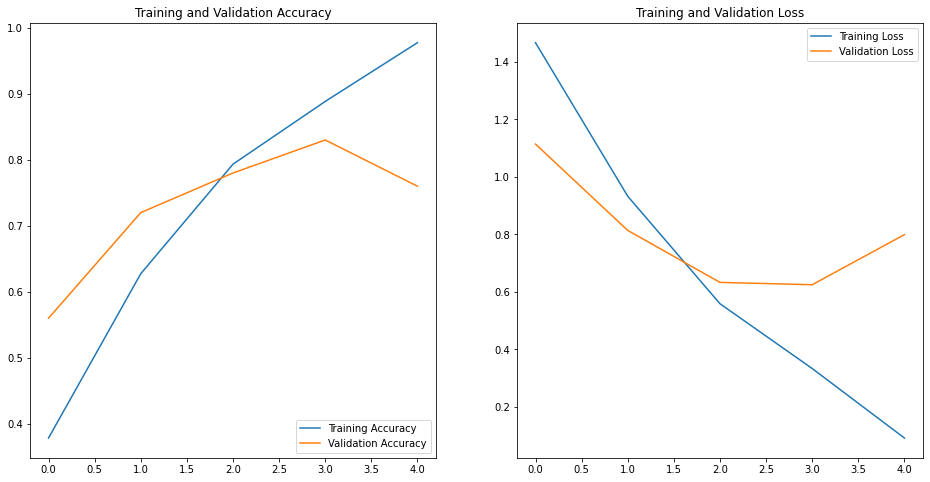

In [26]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
cnn_rnn_m5.save('model-11.h5')